In [26]:
# Importar modulos a emplear
import pandas as pd
import sys
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from datetime import timedelta

# Importar las funciones desde helpers.modelo
from helpers.modelo import comprobar_dispositivo, preparar_datos_lstm, LSTMModel

# Agregar la carpeta raíz del proyecto a las rutas de búsqueda de Python
base_dir = os.getcwd()  # Obtiene el directorio actual (donde está la libreta)
sys.path.append(base_dir)  # Agrega la carpeta raíz del proyecto a las rutas de búsqueda

# Definir la ruta base y cargar los datos limpios
base_dir = os.getcwd()
procesados_dir = os.path.join(base_dir, "data", "procesados")

# Importamos el dato limpio

In [27]:
# Cargar los datos limpios
ventas_df = pd.read_csv(os.path.join(procesados_dir, "ventas_limpio.csv"))
productos_df = pd.read_csv(os.path.join(procesados_dir, "productos_limpio.csv"))
ciudad_df = pd.read_csv(os.path.join(procesados_dir, "ciudad_limpio.csv"))

# Union de tablas

In [28]:
# Unir las tablas
# Unir ventas con productos (por Cod_Producto)
ventas_productos = pd.merge(ventas_df, productos_df, on="cod_producto")

# Unir el resultado con ciudad (por Cod_Ciudad)
ventas_completa = pd.merge(ventas_productos, ciudad_df, on="cod_ciudad")

# Calcular ingresos, costos y beneficios
ventas_completa["Ingresos"] = ventas_completa["precio_unitario"] * ventas_completa["unidades_vendidas"]
ventas_completa["Costo_Total"] = (
    (ventas_completa["costo_unitario"] * ventas_completa["unidades_vendidas"])
    + ventas_completa["costo_asociado_al_domicilio"]
)
ventas_completa["Beneficio"] = ventas_completa["Ingresos"] - ventas_completa["Costo_Total"]

# Asegúrate de que la columna de fechas esté en formato datetime
ventas_completa["fecha_orden"] = pd.to_datetime(ventas_completa["fecha_orden"])

# Edición de los datos

In [29]:
# Agrupar los datos por fecha y calcular el total de beneficio diario
beneficios_diarios = ventas_completa.groupby("fecha_orden")["Beneficio"].sum().reset_index()

In [30]:
# Crear un rango completo de fechas
rango_fechas = pd.date_range(
    start=beneficios_diarios["fecha_orden"].min(),
    end=beneficios_diarios["fecha_orden"].max(),
    freq="D"
)

# Reindexar para asegurarte de que todas las fechas estén presentes
beneficios_diarios = beneficios_diarios.set_index("fecha_orden").reindex(rango_fechas, fill_value=0).reset_index()
beneficios_diarios.columns = ["fecha_orden", "beneficio"]

In [31]:
# Crear lags (valores de días anteriores)
for lag in range(1, 8):  # Lags de 1 a 7 días
    beneficios_diarios[f"lag_{lag}"] = beneficios_diarios["beneficio"].shift(lag)

In [32]:
# Crear medias móviles
beneficios_diarios["media_movil_3"] = beneficios_diarios["beneficio"].rolling(window=3).mean()
beneficios_diarios["media_movil_7"] = beneficios_diarios["beneficio"].rolling(window=7).mean()

In [33]:
# Extraer características temporales
beneficios_diarios["mes"] = beneficios_diarios["fecha_orden"].dt.month
beneficios_diarios["dia_mes"] = beneficios_diarios["fecha_orden"].dt.day
beneficios_diarios["dia_semana"] = beneficios_diarios["fecha_orden"].dt.weekday  # 0 = Lunes, 6 = Domingo
beneficios_diarios["es_fin_de_semana"] = beneficios_diarios["dia_semana"].isin([5, 6]).astype(int)

In [34]:
# Extraer variación porcentual diaria
beneficios_diarios["variacion_diaria"] = beneficios_diarios["beneficio"].pct_change()

In [35]:
# Rellenar NaN con 0 o forward-fill para medias móviles y variaciones
beneficios_diarios.fillna(0, inplace=True)

In [36]:
# Definir las columnas a normalizar
columnas_a_normalizar = ["beneficio", "lag_1", "lag_2", "lag_3", "lag_4", 
                         "lag_5", "lag_6", "lag_7", "media_movil_3", 
                         "media_movil_7", "variacion_diaria"]

# Separar las columnas categóricas y binarias
columnas_categoricas = ["mes", "dia_mes", "dia_semana", "es_fin_de_semana"]

# Crear una copia del DataFrame original para normalizar
beneficios_diarios_normalizados = beneficios_diarios.copy()

# Escalador independiente para la columna 'beneficio'
scaler_beneficio = MinMaxScaler()
beneficios_diarios_normalizados["beneficio"] = scaler_beneficio.fit_transform(
    beneficios_diarios[["beneficio"]]
)

# Escalador para las demás columnas continuas
scaler_continuas = MinMaxScaler()
beneficios_diarios_normalizados[columnas_a_normalizar[1:]] = scaler_continuas.fit_transform(
    beneficios_diarios[columnas_a_normalizar[1:]]
)

# Entrenar el Modelo

## Generacion de tensores

In [37]:
# Crear ventanas deslizantes
columnas_modelo = columnas_a_normalizar + ["mes", "dia_mes", "dia_semana", "es_fin_de_semana"]

X, y = preparar_datos_lstm(data=beneficios_diarios_normalizados[columnas_modelo], 
                           target_col="beneficio", 
                           lag=7)

# Verificar dimensiones
print("Dimensiones de X:", X.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y:", y.shape)  # (n_secuencias,)

Dimensiones de X: (84, 7, 15)
Dimensiones de y: (84,)


In [38]:
# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Verificar dimensiones
print("Dimensiones de X_train:", X_train.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y_train:", y_train.shape)  # (n_secuencias,)

Dimensiones de X_train: (67, 7, 15)
Dimensiones de y_train: (67,)


In [39]:
# Verificar dimensiones
print("Dimensiones de X_train:", X_train.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y_train:", y_train.shape)  # (n_secuencias, 1)

Dimensiones de X_train: (67, 7, 15)
Dimensiones de y_train: (67,)


In [40]:
# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Verificar dimensiones nuevamente
print("Dimensiones de X_train:", X_train.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y_train:", y_train.shape)  # (n_secuencias, 1)

Dimensiones de X_train: torch.Size([67, 7, 15])
Dimensiones de y_train: torch.Size([67, 1])


## Configuracion y aplicacion de la red Neuronal

In [41]:
# Configurar modelo
input_size = X_train.shape[2]  # Número de características
hidden_size = 50
num_layers = 2

# Comprobacion de uso de CUDA o CPU
device = comprobar_dispositivo()

# Instanciar el modelo
model = LSTMModel(input_size, hidden_size, num_layers, device).to(device)

CUDA está disponible. Los modelos pueden ser entrenados en GPU.
Cantidad de GPUs disponibles: 1
Nombre de la GPU: NVIDIA GeForce RTX 4060 Ti


In [42]:
# Configurar función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
epochs = 1000
for epoch in range(epochs):
    model.train()
    X_train, y_train = X_train.to(device), y_train.to(device)
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.0598
Epoch [20/1000], Loss: 0.0456
Epoch [30/1000], Loss: 0.0435
Epoch [40/1000], Loss: 0.0434
Epoch [50/1000], Loss: 0.0427
Epoch [60/1000], Loss: 0.0418
Epoch [70/1000], Loss: 0.0410
Epoch [80/1000], Loss: 0.0398
Epoch [90/1000], Loss: 0.0380
Epoch [100/1000], Loss: 0.0352
Epoch [110/1000], Loss: 0.0321
Epoch [120/1000], Loss: 0.0306
Epoch [130/1000], Loss: 0.0290
Epoch [140/1000], Loss: 0.0275
Epoch [150/1000], Loss: 0.0259
Epoch [160/1000], Loss: 0.0239
Epoch [170/1000], Loss: 0.0213
Epoch [180/1000], Loss: 0.0189
Epoch [190/1000], Loss: 0.0161
Epoch [200/1000], Loss: 0.0142
Epoch [210/1000], Loss: 0.0125
Epoch [220/1000], Loss: 0.0113
Epoch [230/1000], Loss: 0.0099
Epoch [240/1000], Loss: 0.0093
Epoch [250/1000], Loss: 0.0083
Epoch [260/1000], Loss: 0.0075
Epoch [270/1000], Loss: 0.0067
Epoch [280/1000], Loss: 0.0062
Epoch [290/1000], Loss: 0.0058
Epoch [300/1000], Loss: 0.0057
Epoch [310/1000], Loss: 0.0046
Epoch [320/1000], Loss: 0.0043
Epoch [330/1000],

In [43]:
# Evaluar el modelo
model.eval()
with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    predictions = model(X_test).cpu().numpy()
    y_test = y_test.cpu().numpy()

In [44]:
# Asegúrate de que las predicciones tienen la forma (n, 1)
predictions = predictions.reshape(-1, 1)

# Invertir la normalización de las predicciones
predictions_originales = scaler_beneficio.inverse_transform(predictions)

# Desnormalizar los valores reales para comparación
y_test = y_test.reshape(-1, 1)
y_test_originales = scaler_beneficio.inverse_transform(y_test)

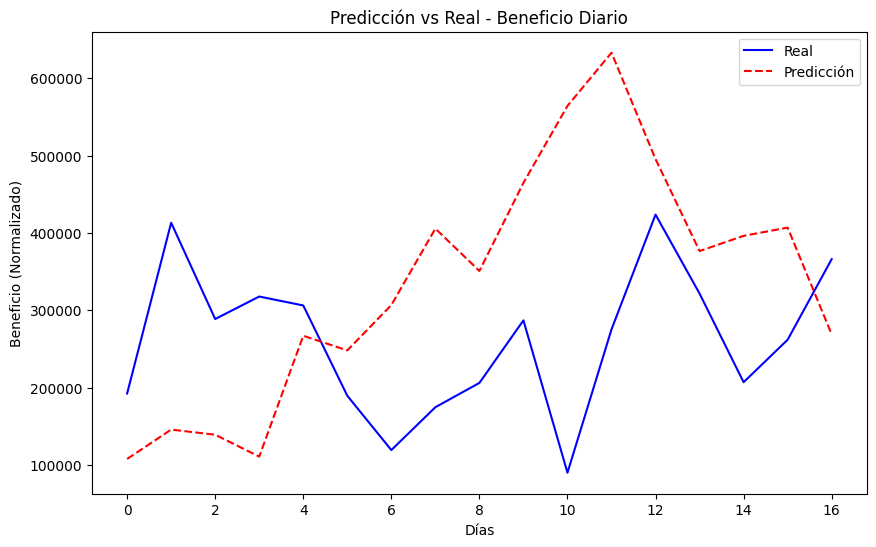

In [45]:
# Verificamos la prediccion contra el valor real
plt.figure(figsize=(10, 6))
plt.plot(y_test_originales, label="Real", color="blue")
plt.plot(predictions_originales, label="Predicción", color="red", linestyle="--")
plt.title("Predicción vs Real - Beneficio Diario")
plt.xlabel("Días")
plt.ylabel("Beneficio (Normalizado)")
plt.legend()
plt.show()

## Guardar el modelo

In [46]:
# Definir la ruta de la carpeta 'models'
models_dir = os.path.join(os.getcwd(), "models")
os.makedirs(models_dir, exist_ok=True)

# Ruta completa para guardar el modelo
model_path = os.path.join(models_dir, "modelo_lstm_beneficio.pth")

# Guardar el modelo entrenado
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado correctamente en: {model_path}")

Modelo guardado correctamente en: f:\Python\Entrevistas\modelo\models\modelo_lstm_beneficio.pth


# Aplicar el modelo entrenado

In [47]:
# Generar un rango de fechas para abril
fecha_inicio = beneficios_diarios["fecha_orden"].max() + timedelta(days=1)
fecha_fin = fecha_inicio + timedelta(days=29)  # Del 1 al 30 de abril
fechas_abril = pd.date_range(fecha_inicio, fecha_fin)

# Inicializar un DataFrame para las predicciones futuras
predicciones_futuras = pd.DataFrame(columns=beneficios_diarios.columns)
predicciones_futuras["fecha_orden"] = fechas_abril

# Usar las últimas 7 filas de marzo como base para generar datos futuros
ultimos_datos = beneficios_diarios_normalizados.iloc[-7:].copy()

In [48]:
for fecha in fechas_abril:
    # Crear la nueva fila con las características necesarias
    nueva_fila = {}
    nueva_fila["lag_1"] = ultimos_datos["beneficio"].iloc[-1]
    nueva_fila["lag_2"] = ultimos_datos["lag_1"].iloc[-1]
    nueva_fila["lag_3"] = ultimos_datos["lag_2"].iloc[-1]
    nueva_fila["lag_4"] = ultimos_datos["lag_3"].iloc[-1]
    nueva_fila["lag_5"] = ultimos_datos["lag_4"].iloc[-1]
    nueva_fila["lag_6"] = ultimos_datos["lag_5"].iloc[-1]
    nueva_fila["lag_7"] = ultimos_datos["lag_6"].iloc[-1]

    # Calcular medias móviles (en la escala normalizada)
    nueva_fila["media_movil_3"] = ultimos_datos["beneficio"].iloc[-3:].mean()
    nueva_fila["media_movil_7"] = ultimos_datos["beneficio"].mean()

    # Calcular la variación diaria
    nueva_fila["variacion_diaria"] = (
        (nueva_fila["lag_1"] - nueva_fila["lag_2"]) / nueva_fila["lag_2"]
        if nueva_fila["lag_2"] != 0
        else 0
    )

    # Día de la semana, mes, día del mes, etc.
    nueva_fila["mes"] = fecha.month
    nueva_fila["dia_mes"] = fecha.day
    nueva_fila["dia_semana"] = fecha.weekday()
    nueva_fila["es_fin_de_semana"] = 1 if fecha.weekday() >= 5 else 0

    # Añadir un valor inicial de 'beneficio' como placeholder
    nueva_fila["beneficio"] = 0  # Este valor se actualizará con la predicción

    # Convertir a DataFrame
    nueva_fila_df = pd.DataFrame([nueva_fila])

    # Normalizar las columnas continuas (excluyendo 'beneficio')
    columnas_a_normalizar_sin_beneficio = [
        col for col in columnas_a_normalizar if col != "beneficio"
    ]
    nueva_fila_df[columnas_a_normalizar_sin_beneficio] = scaler_continuas.transform(
        nueva_fila_df[columnas_a_normalizar_sin_beneficio]
    )

    # Asegurar que las columnas estén en el orden correcto para el modelo
    X_nueva = torch.tensor(
        nueva_fila_df[columnas_modelo].values, dtype=torch.float32
    ).to(device)

    # Añadir dimensión de batch size
    X_nueva = X_nueva.unsqueeze(0)  # Convertir a (1, sequence_length, num_features)

    # Realizar la predicción con el modelo
    model.eval()
    with torch.no_grad():
        prediccion_normalizada = model(X_nueva).cpu().numpy()[0][0]

    # Desnormalizar la predicción para obtener el beneficio original
    prediccion_original = scaler_beneficio.inverse_transform([[prediccion_normalizada]])[0][0]

    # Guardar la predicción en el DataFrame
    predicciones_futuras.loc[fecha, "beneficio"] = prediccion_original

    # Actualizar los datos para la siguiente iteración
    nueva_fila["beneficio"] = prediccion_normalizada  # Actualizar con la predicción normalizada
    ultimos_datos = pd.concat([ultimos_datos, pd.DataFrame([nueva_fila])], ignore_index=True).iloc[-7:]


In [49]:
# Resetear el índice para tener una estructura limpia
predicciones_futuras_limpio = predicciones_futuras.reset_index().copy()

# Filtrar las filas donde 'beneficio' no es NaN
predicciones_futuras_limpio = predicciones_futuras_limpio[predicciones_futuras_limpio["beneficio"].notna()]

# Seleccionar solo las columnas 'index' y 'beneficio'
predicciones_futuras_limpio = predicciones_futuras_limpio[["index", "beneficio"]].copy()

# Renombrar la columna 'index' a 'fecha_orden'
predicciones_futuras_limpio.rename(columns={"index": "fecha_orden"}, inplace=True)

# Convertir la columna 'fecha_orden' a formato datetime
predicciones_futuras_limpio["fecha_orden"] = pd.to_datetime(predicciones_futuras_limpio["fecha_orden"])

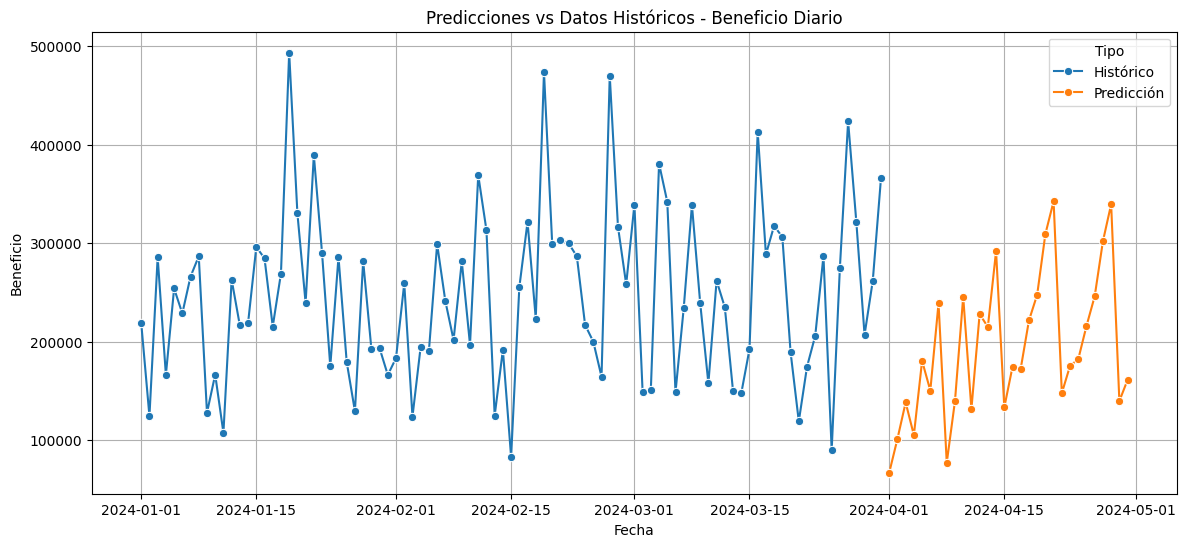

In [50]:
# Asegurarte de que las fechas sean del mismo tipo para ambos DataFrames
beneficios_diarios["fecha_orden"] = pd.to_datetime(beneficios_diarios["fecha_orden"])
predicciones_futuras_limpio["fecha_orden"] = pd.to_datetime(predicciones_futuras_limpio["fecha_orden"])

# Agregar una columna para distinguir datos históricos y predicciones
beneficios_diarios["tipo"] = "Histórico"
predicciones_futuras_limpio["tipo"] = "Predicción"

# Combinar ambos DataFrames
datos_combinados = pd.concat([beneficios_diarios, predicciones_futuras_limpio], ignore_index=True)

# Graficar con seaborn
plt.figure(figsize=(14, 6))
sns.lineplot(data=datos_combinados, x="fecha_orden", y="beneficio", hue="tipo", marker="o")
plt.title("Predicciones vs Datos Históricos - Beneficio Diario")
plt.xlabel("Fecha")
plt.ylabel("Beneficio")
plt.legend(title="Tipo")
plt.grid(True)
plt.show()